In [137]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.linalg as spl
import sklearn.mixture

# Algorithme EM - Application à des données non simulées

Dans ce TP, nous allons étudier des données issues de l'article suivant : 

- Bachrach LK, Hastie T, Wang M-C, Narasimhan B, Marcus R. *Bone Mineral Acquisition in Healthy Asian, Hispanic, Black and Caucasian Youth. A Longitudinal Study.* J Clin Endocrinol Metab (1999) 84, 4702-12. 

Ces données son disponibles [ici](http://www.math-info.univ-paris5.fr/~jdelon/enseignement/densitesOs.txt). Récupérez les et placez les dans le même répertoire que votre notebook. 
Elles représentent des mesures relatives de densité minérale osseuse spinale sur des adolescents  nord-américains. Chaque valeur est la différence de mesures prises sur deux visites consécutives, divisées par la moyenne.

L'idée est de savoir si la population peut être décrite par un mélange de deux gaussiennes. 
Le but est donc d'appliquer à ces données l'algorithme EM, vérifier que le $K$ optimal de la méthode de sélection de modèle vue en cours est bien $K=2$ et proposer un clustering de ces observations. 

On commence par créer le tableau de donnees "data" à partir du fichier.

In [161]:
data = np.loadtxt("/Users/bouacha_lazhar/OneDrive/Master MMA/M2 MMA/M2 S3/Algorithmes stochastiques/densitesOs.txt")
n, d = data.shape
n, d

(485, 2)

## Données

**1) De quelle dimension sont les données ? Affichez les données sous la forme d'un nuage de points.**

Les données sont de la forme nxm avec n le nombre de points et m les coordonnées du point.

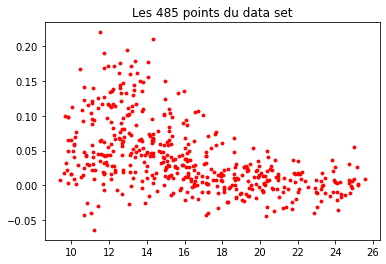

In [162]:
fig = plt.figure()
plt.scatter(data[:, 0], data[:, 1], c = 'red', s = 8)
plt.title('Les 485 points du data set')
plt.show()

## Algorithme EM

**2) On va maintenant appliquer l'algorithme EM aux données précédentes.** 
   - **Ecrire une fonction `EM(K,nbpas,data)` prenant en entrée les données 'data', un entier K (nombre de gaussiennes du mélange) et un nombre de pas nbpas.**
    - **Appliquer la fonction précédente aux données pour les paramètres du GMM sous-jacent pour un nombre de classes K donné.**
 

In [140]:
def EM(K, nbpas, data):
    n, d = data.shape
    alpha = np.random.rand(K)
    alpha /= np.sum(alpha)
    m = np.mean(data, axis = 0)
    mu = []
    G = np.cov(data.T)
    Gdata = [G]*K
    for k in range(K):
        mu.append(np.random.multivariate_normal(mean = m, cov = G, size = 1)[0])
    for i in range(nbpas):
        Pzx = []
        for Xi in data:
            pzx = np.array([alpha[k]*sps.multivariate_normal.pdf(x = Xi, mean = mu[k], cov = Gdata[k]) for k in range(K)])
            Pzx.append(pzx/np.sum(pzx))
        Pzx = np.array(Pzx)
        alpha = np.mean(Pzx, axis = 0)
        for k in range(K):
            mu[k] = np.average(data, axis = 0, weights = Pzx[:,k])
            Gdata[k] = np.cov(data.T, aweights = Pzx[:,k])
    return alpha, mu, Gdata

On fixe le nombre de pas de EM et un intervalle pour les valeurs de K que l'on va tester. 

In [141]:
nbpas = int(5e1) # nombre de pas dans EM
rangeK = range(1,5) # valeurs de K testees pour le nombre de classes (dans la selection de modele)

for K in rangeK:
    (alpha_em, mu_em, covariance_em) = EM(K, nbpas, data)
    print("\nEstimation de alpha pour K = "+str(K)+":\n")
    print(alpha_em)
    
    print("\nEstimation de mu pour K = "+str(K)+":\n")
    for k in range(K):
        print("\nClasse "+str(k)+" :")
        print(mu_em[k])
        
    print("\nEstimation de la covariance pour K = "+str(K)+":\n")
    for k in range(K):
        print("\nClasse "+str(k)+" :")
        print(covariance_em[k])


Estimation de alpha pour K = 1:

[1.]

Estimation de mu pour K = 1:


Classe 0 :
[16.09525773  0.03925155]

Estimation de la covariance pour K = 1:


Classe 0 :
[[ 1.66304010e+01 -1.03221873e-01]
 [-1.03221873e-01  2.46413156e-03]]

Estimation de alpha pour K = 2:

[0.40968162 0.59031838]

Estimation de mu pour K = 2:


Classe 0 :
[12.74575534  0.07709322]

Classe 1 :
[1.84198162e+01 1.29893951e-02]

Estimation de la covariance pour K = 2:


Classe 0 :
[[3.14733278e+00 1.13280153e-02]
 [1.13280153e-02 2.78359926e-03]]

Classe 1 :
[[ 1.27884903e+01 -3.34161801e-02]
 [-3.34161801e-02  5.60124159e-04]]

Estimation de alpha pour K = 3:

[0.2899023  0.19858887 0.51150883]

Estimation de mu pour K = 3:


Classe 0 :
[14.27939763  0.08144431]

Classe 1 :
[11.3898664   0.05324973]

Classe 2 :
[1.89512405e+01 9.90375520e-03]

Estimation de la covariance pour K = 3:


Classe 0 :
[[ 2.98827152e+00 -4.72258277e-02]
 [-4.72258277e-02  2.80243948e-03]]

Classe 1 :
[[1.12687693 0.00633916]
 [0.006339

## Sélection de modèle

Pour la sélection de modèle, il faut calculer la log-vraisemblance et la complexité du modèle.

Une manière classique de choisir le nombre de composantes $K$ dans un intervalle d'entiers est de minimiser en $K$ 
 $$-\ell(x;\widehat{\theta}_K)+ \frac{\operatorname{dim}_K \times \log n}{2},$$
 avec 
 + $\widehat{\theta}_K$ l'estimateur de $\theta$ issu de l'algorithme EM dans le modèle de mélange avec $K$ classes,
 + $\ell(x;\hat{\theta}_K)$ la  log-vraisemblance de l'échantillon   observé $(x_1,\dots , x_n)$ 
 + $\operatorname{dim}_K$ le nombre de degrés de liberté   du modèle de mélange utilisé avec $K$ classes (voir le cours).

Le K optimal pour la sélection de modèle est l'argmin de cette fonction.

**3) Ecrire une fonction `logLikelyhood(K,alpha,mu,Cov,data)` permettant de calculer la vraisemblance du GMM donné par les paramètres (K,alpha,mu,Cov) sur les données `data`.** 

**4) Implémenter la sélection de modèle et l'appliquer aux données précédentes pour déterminer le K optimal. Commentez le résultat.**

**5) Afficher les données en les colorant en fonction de leur classe telle qu'estimée par EM.**

**6) Afficher la fonction  $-\ell(x;\widehat{\theta}_K)+ \frac{\operatorname{dim}_K \times \log n}{2},$ en fonction de $K$**


In [142]:
def logLikelyhood(K, alpha, mu, Cov, data):
    LogX = []
    densite = []
    for Xi in data:
        densite.append(np.sum([alpha[k]*sps.multivariate_normal.pdf(x = Xi, mean = mu[k], cov = Cov[k]) for k in range(K)]))
    LogX.append(np.log(densite))
    return np.sum(LogX)

In [143]:
lxk = []
for K in rangeK:
    alpha, mu, Cov = EM(K, nbpas, data)
    lxk.append(logLikelyhood(K, alpha, mu, Cov, data))
    print("\nLog-vraisemblance du GMM pour K = " +str(K)+ ":\n")
    print(lxk[K-1])


Log-vraisemblance du GMM pour K = 1:

-527.6409714862295

Log-vraisemblance du GMM pour K = 2:

-395.6374297137885

Log-vraisemblance du GMM pour K = 3:

-385.6323532278749

Log-vraisemblance du GMM pour K = 4:

-375.32963689228643


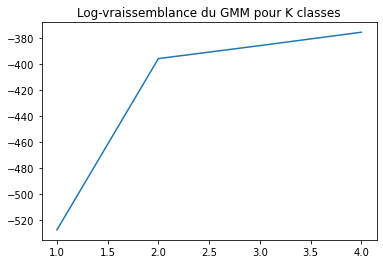

In [151]:
plt.plot(rangeK, lxk)
plt.title('Log-vraissemblance du GMM pour K classes')
plt.show()

In [144]:
def selection_modele(l, K, data):
    n, d = data.shape
    dimK = (0.5*d*(d+1) + d)*K + K - 1
    return -l + 0.5*dimK*np.log(n)

In [145]:
modelK = []
for K in rangeK:
    alpha, mu, Cov = EM(K, nbpas, data)
    modelK.append(selection_modele(lxk[K-1], K, data))
    print("\nSélection de modèle GMM pour K = " +str(K)+ ":\n")
    print(modelK[K-1])


Sélection de modèle GMM pour K = 1:

543.1013437135732

Sélection de modèle GMM pour K = 2:

429.65024861394465

Sélection de modèle GMM pour K = 3:

438.1976188008435

Sélection de modèle GMM pour K = 4:

446.44734913806747


### On remarque que l'argmin de la sélection de modèle est K = 2 donc il faut 2 classes pour notre modèle. C'est bien le résultat attendu pour ces données.

In [180]:
def cluster_proba(K, alpha, mu, Cov, data):
    proba = []
    for Xi in data:
        densite = [alpha[k]*sps.multivariate_normal.pdf(x = Xi, mean = mu[k], cov = Cov[k]) for k in range(K)]
        S = np.sum(densite)
        proba.append(densite/S)
    return np.array(proba)

In [181]:
K = 2
alpha, mu, Cov = EM(K, nbpas, data)
proba = cluster_proba(K, alpha, mu, Cov, data)
x1 = np.where(proba[:,0] > 0.5)[0]
x2 = np.where(proba[:,0] < 0.5)[0]
print('taille classe 0:', x1.shape, 'taille classe 1:', x2.shape)

taille classe 0: (212,) taille classe 1: (273,)


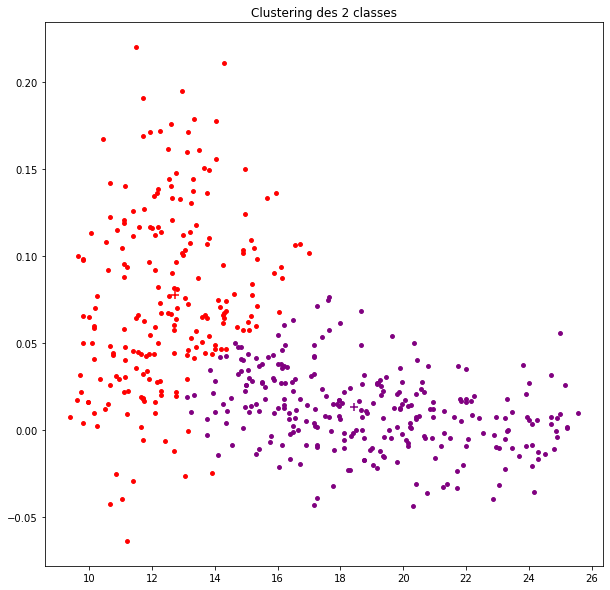

In [192]:
fig = plt.figure(figsize = (10,10))
colorset = ['red', 'purple']

for i, m, c in zip(range(K), mu, Cov):
    densite = sps.multivariate_normal(mean = m, cov = c)
    if i == 0:
        plt.scatter(data[x1,0], data[x1,1], c = colorset[i], s = 15)
    elif i == 1:
        plt.scatter(data[x2,0], data[x2,1], c = colorset[i], s = 15)
    else:
        pass
    plt.scatter(m[0], m[1], c = colorset[i], s = 50, marker = '+')
    plt.title('Clustering des 2 classes')
plt.show()

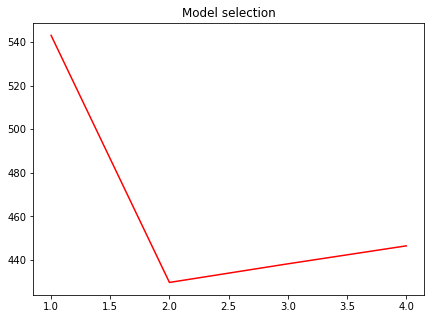

In [169]:
x = rangeK
y = modelK
fig = plt.figure(figsize = (7,5))
plt.plot(x, y, color = 'red')
plt.title('Model selection')
plt.show()

## En utilisant la librarie sklearn

Refaire la même chose en utilisant la fonction `sklearn.mixture.GaussianMixture` de la bibliothèque `scikit-learn`. Voir [la page suivante](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)




Converged: True
taille classe 0: (249,) taille classe 1: (236,)


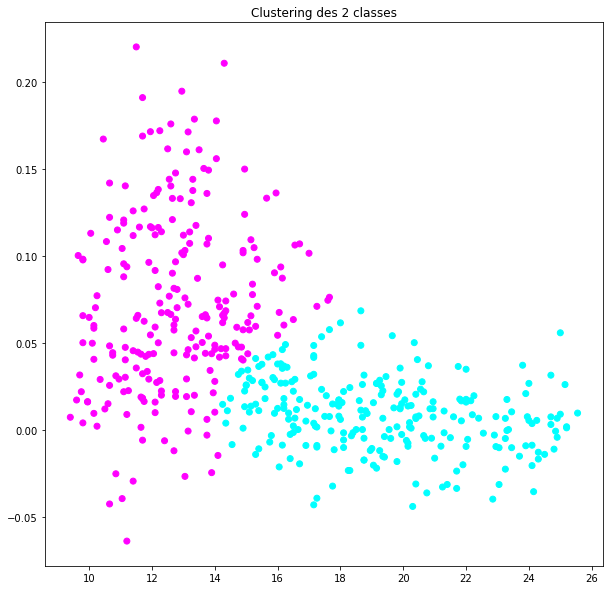

In [191]:
K = 2
GMM = sklearn.mixture.GaussianMixture(n_components = K, random_state = 0).fit(data) # Instantiate and fit the model
print('Converged:', GMM.converged_) # Check if the model has converged

# Predict
labels = GMM.predict(data)
print('taille classe 0:', labels[labels == 0].shape, 'taille classe 1:', labels[labels == 1].shape)

# Plot   
fig = plt.figure(figsize = (10,10))
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'cool')
plt.title('Clustering des 2 classes')
plt.show()